# CNN autoencoder

## 1. Imports, functions and constants

In [1]:
from CNN import *
from GradCAMUtils import *
from Utils_auto import *
from Autoencoder import *

In [2]:
"""Constants"""
# sequence length indicate the maximum length for all of the sequnence 626/798
SEQUENCE_LENGTH = 798

BATCH_SIZE = 16

vocab = {'C': [0,0,1], 'H': [0,1,0], 'E': [1,0,0], '-':[0,0,0]}

# Transform the labels from String to Integer via LabelEncoder
le_fold = preprocessing.LabelEncoder()
le_fam = preprocessing.LabelEncoder()

# torch.cuda.set_device()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

cuda_gpu = torch.cuda.is_available()   #check if gpu is avaliable

torch.cuda.empty_cache()

## 2. Load dataset and models

In [3]:
# load pretrained final model
model = pickle.load(open("../PretrainedModels/CNNAttention.pickle", 'rb'))

In [4]:
# cluster definition
GTA_0 = ["GT14-A", "GT16-A", "GT2-A","GT25-A","GT45-A", "GT49-A", "GT60-A"]
GTA_1 = ["GT15-A","GT17-A","GT31-A","GT34-A","GT43-A","GT6-A","GT62-A","GT67-A","GT7-A","GT77-A"]
GTB_0 = ["GT1-B","GT10-B","GT20-B","GT28-B","GT37-B","GT38-B","GT4-B","GT47-B","GT5-B","GT63-B","GT72-B","GT79-B","GT9-B","GT90-B","GT93-B"]
GTB_1 = ["GT23-B","GT3-B","GT35-B","GT41-B"]
GTB_1 = ["GT104-B","GT30-B","GT70-B"]
GTC_0 = ["GT39-C","GT57-C","GT66-C"]
GTC_1 = ["GT50-C","GT58-C","GT87-C"]
GTC_2 = ["GT22-C","GT83-C"]

In [5]:
# load data
df = pd.read_csv("../Datasets/Training_data/gt_training.autoencoder.csv")

df_cluter = df.loc[df['family'].isin(GTA_0)]

train_df, val_df = train_test_split(df_cluter, test_size=0.05, shuffle=False)
test_df = df.loc[df.fold=="A"].loc[~df['family'].isin(GTA_0)]

df_gtu = pd.read_csv("../Datasets/gtu/gtu.processed.csv")

Train_ds, Train_dl = Dataset_Loader(train_df, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

Val_ds, Val_dl = Dataset_Loader(val_df, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

Test_ds, Test_dl = Dataset_Loader(test_df, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

Val_u_ds, Val_u_dl = Dataset_Loader(df_gtu, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

In [6]:
df_A = df.loc[df["fold"]=="A"]
df_B = df.loc[df["fold"]=="B"]
df_C = df.loc[df["fold"]=="C"]
df_Lyso = df.loc[df["fold"]=="lyso"]

## 3. Model training

/home/zzl/anaconda3/envs/GT_test/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :1 	Training Loss :37.706268.
Epoch :1 	Val Loss :32.687192.
Epoch :1 	Val OOD Loss :31.236634.
Validation loss decreased (inf --> 32.687192).  Saving model ...


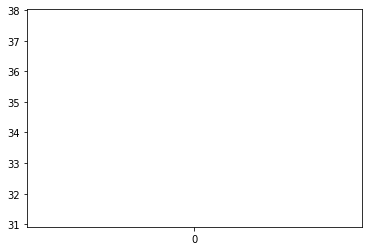

In [8]:
# training the model
model_autoencoder = autoencoder(model).cuda()
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_autoencoder.parameters()), lr=1e-5)

model_A = fit_autoencoder(1, model_autoencoder, criterion, optimizer, Train_dl, Val_dl, Val_u_dl, patience=1)

## 4. Load for inference

In [10]:
# load for inference

model = pickle.load(open('../PretrainedModels/Autoencoder_gta0.pickle','rb'))

In [12]:
def get_rerr(df, le_fam, le_fold, vocab, BATCH_SIZE=1, cuda=cuda_gpu, model=model):
    reconstruction_err = []
    for i, data in enumerate(Train_dl, 0):
        model_A.eval()

        xb, yb, p = data
        output = model(xb)
        xb = xb.float()
        loss = criterion(output, xb)/(p.sum())

        reconstruction_err.append([df.iloc[i].family, loss.item()])

    return pd.DataFrame(reconstruction_err, columns=["fold", "Err"])

In [15]:
rerr_A = get_rerr(df=df_cluter, le_fam=le_fam, le_fold=le_fold, vocab=vocab, BATCH_SIZE=1, cuda=cuda_gpu, model=model)
rerr_B = get_rerr(df=df_B, le_fam=le_fam, le_fold=le_fold, vocab=vocab, BATCH_SIZE=1, cuda=cuda_gpu, model=model)
rerr_C = get_rerr(df=df_C, le_fam=le_fam, le_fold=le_fold, vocab=vocab, BATCH_SIZE=1, cuda=cuda_gpu, model=model)
rerr_lyso = get_rerr(df=df_Lyso, le_fam=le_fam, le_fold=le_fold, vocab=vocab, BATCH_SIZE=1, cuda=cuda_gpu, model=model)
rerr_gtu = get_rerr(df=df_gtu, le_fam=le_fam, le_fold=le_fold, vocab=vocab, BATCH_SIZE=1, cuda=cuda_gpu, model=model)

In [ ]:
rerr_A.to_csv("rerr_gta0_training.csv", index = False)
alltest_rerr= pd.concat([rerr_B, rerr_C, reconstruction_err_gtc, rerr_lyso, rerr_gtu], axis=0)
alltest_rerr.to_csv("rerr_gta0_Alltest.csv", index = False)